# Wide beam 180º scattering

Paper: [_Optimal laser focusing for positron production in laser-electron scattering_, Óscar Amaro and Marija Vranic 2021 New J. Phys. __23__ 115001](https://iopscience.iop.org/article/10.1088/1367-2630/ac2e83)

Preprint: https://arxiv.org/abs/2106.01877

In this notebook we simulate the ballistic propagation of electrons in a frontal scattering, and show that the distribution of particles is indeed as the one predicted by the analytical expression.

In [1]:
import os
import sys
sys.path.append('../QScatter')
import QScatter
from QScatter import *

In [2]:
## laser
a0 = 1.0; #[] a0
lbd = 0.8; #[\mu m] wavelength
tau = 35; #[fs] pulse duration
tau_micron = tau*1e-15 * speed_of_light * 1e6; #[\mu m] pulse duration in micron
print('tau_micron=',tau_micron,'micron')
W0 = 3.0; #[\mu m] laser spotsize
zR = pi*W0**2/lbd; #[\mu m] laser Rayleight range

## electron beam
sigmax = 24.4; #[\mu m]
sigmay = 29.6; #[\mu m]
L = 100.0; #[\mu m] beam length

def dNda(a):
    """theory"""
    az = a0/sqrt(1+(L/4/zR)**2)
    return np.piecewise(a, [a > az, a <= az], [lambda a: 4*pi*W0**2*zR/a * 1/3/a * sqrt(a0**2-a**2) * ((a0/a)**2+2),
                                               lambda a: 4*pi*W0**2*zR/a * L/4/zR * (1+(L/4/zR)**2/3) ])

tau_micron= 10.49273603 micron


# Distribution

In [3]:
Nsmpl = int(1e6); #[] number of sampled photons
l0 = 1.5*L/2; #[\mu m] initial distance from focus (both for the photons and the laser)

## coordinate data (constant density)
# proper cartesian coordinates
zdist = L*rng.random(Nsmpl)-L/2 - l0; #[\mu m]
xdist = sigmax*rng.standard_normal(Nsmpl) #[\mu m]
ydist = sigmay*rng.standard_normal(Nsmpl) #[\mu m]

In [4]:
# time
tmax = 2*l0 #[\mu m] maximum time after the start of the scattering
tdim = 300 #[] number of samples along the trajectories
dt = tmax/tdim

# distribution in a0
adist_traj = np.zeros((tdim,Nsmpl)) #[] field at each point in the trajectory
adist = np.zeros(Nsmpl) #[] peaked field for each particle

# evolve photons ballistically
for i in trange(tdim):
    t = i*dt #[\mu m]
    
    # get
    adist_traj[i,:] = gauss3D(zdist,xdist,ydist,a0,W0,lbd) * exp(-(t+(zdist-l0))**2/tau_micron**2);
    
    # push electrons
    zdist = zdist + dt

# get peak for each trajectory
for i in trange(Nsmpl):
    adist[i] = np.max( adist_traj[:,i] )

100%|██████████████████████████████| 1000000/1000000 [00:13<00:00, 72904.46it/s]


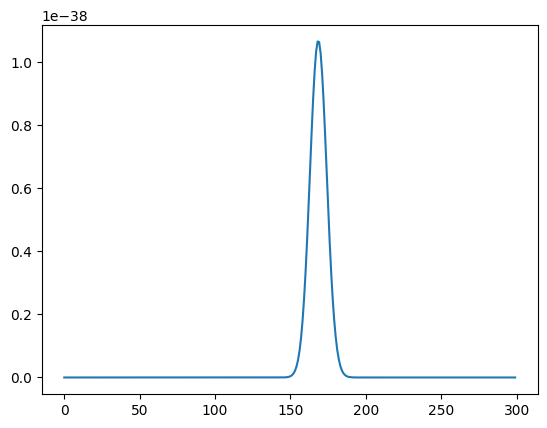

In [5]:
# example of field along trajectory
plt.plot(adist_traj[:,1])
plt.show()

In [6]:
# histogram parameters
nbins = 50; #[]
abins = np.linspace(0.1*a0,0.999*a0,nbins); #[]
da = abins[1]-abins[0]; #[] size of bin

# make histogram for the sampling
adist_y,adist_x = np.histogram(adist,abins)
# sampling distribution
dNda_smpl, a_xaxis = adist_y, np.array(arraycenter(adist_x))
# analytical distribution
dNda_th = dNda(a_xaxis)

# there might be a multiplicative constant missing in the theory
mult_const = np.mean( dNda_th[dNda_smpl!=0]/dNda_smpl[dNda_smpl!=0] )
print(mult_const)

25.223660192293817


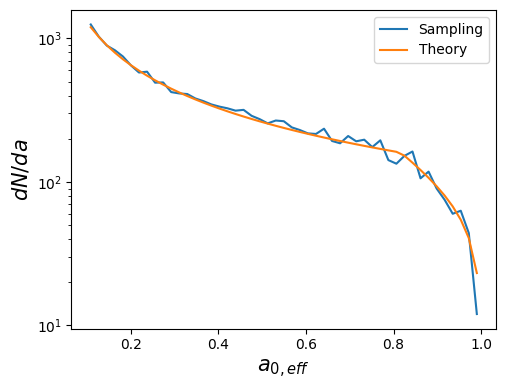

In [10]:
# plot distribution
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plt.plot(a_xaxis,dNda_smpl,label='Sampling')
plt.plot(a_xaxis, dNda_th/mult_const ,label='Theory')
plt.xlabel(r'$a_{0,eff}$',fontsize=15)
plt.ylabel(r'$dN/da$',fontsize=15)
plt.yscale('log')
plt.legend()
# aspect
axes.set_box_aspect(aspect=3/4)
# final
plt.tight_layout()
#plt.savefig('Wide_3D_scatt180.pdf')
plt.show()